In [1]:
import os
import opyplus as op
import matplotlib.pyplot as plt
import pandas as pd
epw_files = os.listdir("data")
weather_dfs = []
base_df = None
for file in epw_files:
    # load weather data object
    try:
        if "USA" in file:
            weather_data = op.WeatherData.from_epw(os.path.join("data", file))
            weather_dfs.append(weather_data.get_weather_series())
            if file == 'USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw':
                base_df = weather_dfs[-1]
    except Exception as e:
        print(e)

### Overall Process of Embedding OU Parameters into a low dimensional space:
We model each weather file as having been generated from an OU process adding noise to the "base" weather of our environment. After recovering the OU parameters, we can encode them in a low dimensional space using PCA, which will capture the covariances between the parameters for each individual variable.

1. Subtract each epw from base epw and rescale using base epw's std deviation
2. Since OU process is auto-generative, we use a linear regression to predict the effect x[t] had on x[t+1]
3. Do some math on the linear regression outputs to recover the MLE of the OU process parameters for each variable for each epw
4. Standardize the recovered OU parameters
5. Fit PCA to the parameters

When generating new epw files:
1. Sample a uniform random variable and multiply it by the PCA
2. Rescale the new parameters by subtracting OU means and variances
3. Rescale again by multiplying OU offset and std parameters by the base epw's std deviation


In [2]:
variables = ['drybulb', 'relhum', "winddir", "dirnorrad", "difhorrad", "windspd", "precip_wtr", "snowdepth"]
base_df = base_df[variables]
df_mean = base_df.mean(0)
df_std = base_df.std(0)
df_std[df_std == 0] = 1
dt = 1/8760

In [3]:
df_std

drybulb         9.003335
relhum         23.782531
winddir        82.218378
dirnorrad     358.688955
difhorrad      86.422528
windspd         1.811650
precip_wtr     84.068268
snowdepth       1.000000
dtype: float64

In [4]:
for i in range(len(weather_dfs)):
    weather_dfs[i] = (weather_dfs[i][variables] - base_df) / (df_std + 0.0000001)

In [5]:
big_df = pd.concat(weather_dfs)
big_df.describe()

,drybulb,relhum,winddir,dirnorrad,difhorrad,windspd,precip_wtr,snowdepth
count,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07
mean,-1.093482e+00,1.360681e+00,-2.219868e-01,-2.825541e-01,9.275677e-02,3.000955e-01,-2.697253e-01,4.333823e-01
std,1.001236e+00,1.203614e+00,1.659077e+00,8.637207e-01,7.952110e-01,1.693164e+00,1.539851e+00,3.715370e+00
min,-8.596814e+00,-3.994529e+00,-4.378583e+00,-2.879933e+00,-6.398794e+00,-7.672564e+00,-5.352793e+00,0.000000e+00
25%,-1.688263e+00,5.886674e-01,-1.459528e+00,-4.683724e-01,0.000000e+00,-8.279746e-01,-1.189509e+00,0.000000e+00
50%,-1.032951e+00,1.471668e+00,-2.432546e-01,0.000000e+00,0.000000e+00,2.759915e-01,-3.568528e-01,0.000000e+00
75%,-4.331728e-01,2.270574e+00,9.730185e-01,0.000000e+00,1.619948e-01,1.324759e+00,5.947547e-01,0.000000e+00
max,3.998518e+00,4.078624e+00,4.378583e+00,3.950498e+00,6.850066e+00,4.117794e+01,7.256008e+00,1.370000e+02


In [6]:
weather_dfs[0].shape

(8760, 8)

In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np
OU_vars = {k: [] for k in weather_dfs[0].columns}
all_OU = []
scores = {k: [] for k in weather_dfs[0].columns}
all_scores = []
coefs = []
intercepts = []
for i in range(len(weather_dfs)):
    if np.any(weather_dfs[i].isna()):
        continue
    for j in range(weather_dfs[i].shape[-1]):
        reg = LinearRegression()
        split = int(8760 * 0.8)
        X_train = np.array(weather_dfs[i].iloc[:split-1, j]).reshape([-1, 1])
        y_train = np.array(weather_dfs[i].iloc[1:split, j]).reshape([-1, 1])
        X_test = np.array(weather_dfs[i].iloc[split:-1, j]).reshape([-1, 1])
        y_test = np.array(weather_dfs[i].iloc[split+1:, j]).reshape([-1, 1])
        reg = reg.fit(X_train, y_train)
        preds = reg.predict(X_train)
        std = np.sqrt(np.mean((preds - y_train) ** 2))
        score = reg.score(X_test, y_test)
        scores[weather_dfs[i].columns[j]].append(score)
        coef = reg.coef_.squeeze().item()
        coefs.append(coef)
        intercept = reg.intercept_.squeeze().item()
        intercepts.append(intercept)
        if coef == 0:
            tau = 0.001
        else:
            tau = dt / (1 - coef) #(1 - dt) / coef
        mu = intercept * tau / dt
        sigma = std / (np.sqrt(dt * 2. / tau))

        OU_vars[weather_dfs[i].columns[j]].append(np.array([sigma, mu, tau]))
        all_OU.append(np.array([sigma, mu, tau]))
        all_scores.append(score)

In [8]:
all_OU = np.stack(all_OU)
all_scores = np.stack(all_scores)

In [9]:
pd.DataFrame(all_scores).describe()

,0
count,11824.000000
mean,0.743307
std,0.241941
min,-4.523659
25%,0.541347
50%,0.785736
75%,0.965271
max,1.000000


In [10]:
{k: np.mean(np.array(var), axis=0) for k, var in OU_vars.items()}

{'drybulb': array([ 0.72918787, -1.11909799,  0.0041514 ]),
 'relhum': array([1.1157683 , 1.36511382, 0.00326103]),
 'winddir': array([ 1.46200430e+00, -2.34226992e-01,  3.48571028e-04]),
 'dirnorrad': array([ 8.04454152e-01, -2.67266879e-01,  5.98230606e-04]),
 'difhorrad': array([7.58214955e-01, 1.20950294e-01, 3.60393860e-04]),
 'windspd': array([1.47887723e+00, 2.26013467e-01, 4.95889862e-04]),
 'precip_wtr': array([ 1.03724484, -0.32147545,  0.02084473]),
 'snowdepth': array([0.65863037, 0.33040698, 0.00648558])}

In [11]:
OU_vars = {k: np.stack(v) for k, v in OU_vars.items()}

In [12]:
from scipy import stats
from copy import deepcopy
from sklearn.model_selection import train_test_split
OU_dict = {}
for i in range(len(OU_vars["drybulb"])):
    for j, var in enumerate(variables):
        for k in range(3):
            OU_dict[f"{var}_{k}"] = OU_vars[var][:, k]
OU_df = pd.DataFrame.from_dict(OU_dict)
OU_df = OU_df[(np.abs(stats.zscore(OU_df)) < 3).all(axis=1)]
OU_df_saved = deepcopy(OU_df)
OU_mean = OU_df.mean(axis=0)
OU_std = OU_df.std(axis=0)
OU_df = (OU_df - OU_df.mean(axis=0)) / (OU_df.std(axis=0))
OU_df_train, OU_df_test = train_test_split(OU_df, test_size=0.2)

In [13]:

for i, column in enumerate(OU_df_saved.columns):
    delim_idx = column.rfind("_")
    var = column[:delim_idx]
    idx = int(column[delim_idx+1:])
    if idx in [0, 1]:
        OU_df_saved.iloc[:, i] *= df_std[i//3]
OU_df_saved.to_csv("US_epw_OU_params.csv", index=False) 

In [14]:
OU_df.shape
# df_std.shape

(1306, 24)

In [15]:
from sklearn.decomposition import IncrementalPCA, KernelPCA, PCA
errs = []
errs_train = []
N = 3
for n in range(1, N):
    #pca = IncrementalPCA(len(variables), batch_size=500)
    pca = KernelPCA(n, kernel="poly", degree=3, fit_inverse_transform=True, alpha=1)
    pca.fit(OU_df_train)
    transformed = pd.DataFrame(pca.transform(OU_df_test))
    transformed_train = pd.DataFrame(pca.transform(OU_df_train))
    y = OU_df_test.to_numpy()
    y_train = OU_df_train.to_numpy()
    y_hat = pca.inverse_transform(transformed.to_numpy())
    y_hat_train = pca.inverse_transform(transformed_train.to_numpy())
    err = np.mean(np.abs((y_hat - y)))
    err_train = np.mean(np.abs((y_hat_train - y_train)))
    errs.append(err)
    errs_train.append(err_train)

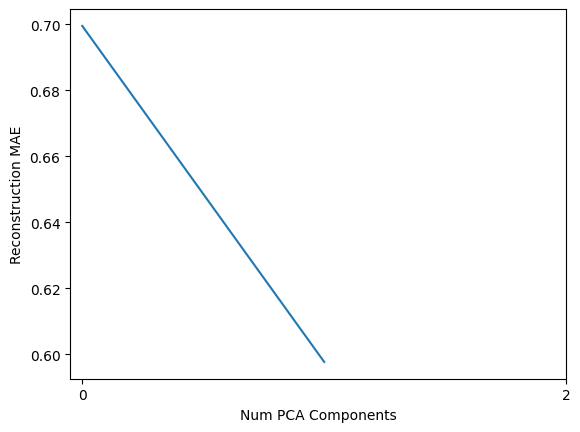

In [16]:
plt.plot(errs_train)
plt.xlabel("Num PCA Components")
plt.ylabel("Reconstruction MAE")
plt.xticks(range(0, N, 2))
plt.show()

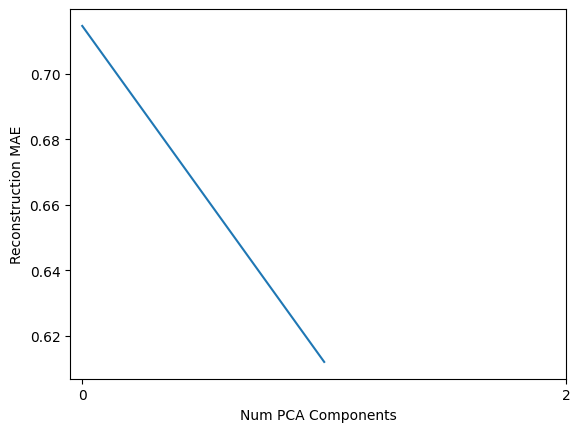

In [17]:
plt.plot(errs)
plt.xlabel("Num PCA Components")
plt.ylabel("Reconstruction MAE")
plt.xticks(range(0, N, 2))
plt.show()

In [18]:
all_transformed = pd.DataFrame(pca.transform(OU_df))
transformed = pd.DataFrame(pca.transform(OU_df_test))
np.mean((transformed - OU_df_test) ** 2)
transformed.describe()

,0,1
count,262.000000,262.000000
mean,0.271060,-0.016287
std,3.253826,0.946822
min,-0.494787,-1.437725
25%,-0.338832,-0.532704
50%,-0.290781,-0.301082
75%,-0.241317,0.155977
max,42.856191,4.801125


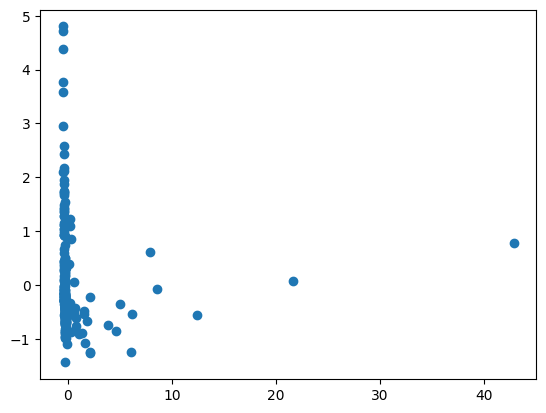

In [19]:
plt.scatter(transformed.iloc[:, 0], transformed.iloc[:, 1])

In [20]:
var_values = pca.eigenvalues_ / sum(pca.eigenvalues_)

<BarContainer object of 2 artists>

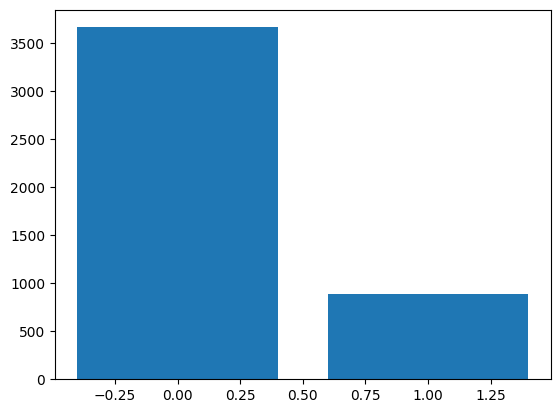

In [21]:
plt.bar(range(len(pca.eigenvalues_)), pca.eigenvalues_)

In [22]:
pca.eigenvectors_

array([[-0.00297567, -0.02399087],
       [-0.00556494, -0.00595297],
       [ 0.00044912, -0.02688654],
       ...,
       [-0.00495392, -0.00920797],
       [ 0.00128281, -0.01333476],
       [-0.00585671,  0.00022453]])

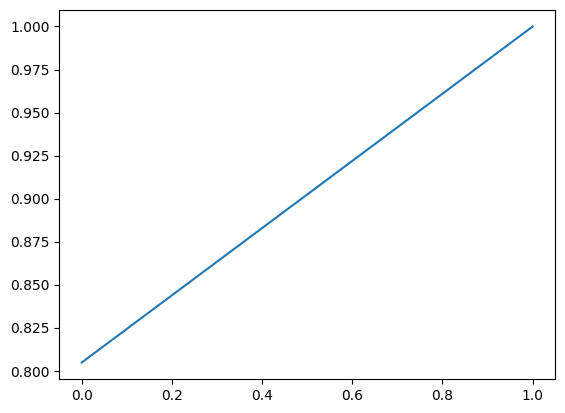

In [23]:
plt.plot(np.cumsum(var_values))

In [24]:
np.cumsum(var_values)

array([0.80477183, 1.        ])

In [25]:
OU_mean

drybulb_0       0.726880
drybulb_1      -1.100279
drybulb_2       0.004113
relhum_0        1.119873
relhum_1        1.396569
relhum_2        0.003250
winddir_0       1.467288
winddir_1      -0.231831
winddir_2       0.000344
dirnorrad_0     0.806122
dirnorrad_1    -0.271714
dirnorrad_2     0.000599
difhorrad_0     0.753601
difhorrad_1     0.128952
difhorrad_2     0.000356
windspd_0       1.467094
windspd_1       0.185073
windspd_2       0.000485
precip_wtr_0    1.048878
precip_wtr_1   -0.211666
precip_wtr_2    0.020536
snowdepth_0     0.289412
snowdepth_1     0.079111
snowdepth_2     0.003044
dtype: float64

In [26]:
# sample = np.random.uniform(-0.5, 0, [1, 3])
sample = np.array([[-0.3, -0.3]])
sampled_OU_vars = pca.inverse_transform(sample)
sampled_OU_vars = sampled_OU_vars * np.array(OU_std)[None, -1] + np.array(OU_mean)[None, -1]
store_OU_mean = deepcopy(OU_mean)
store_OU_std = deepcopy(OU_std)
for i, column in enumerate(OU_df.columns):
    delim_idx = column.rfind("_")
    var = column[:delim_idx]
    idx = int(column[delim_idx+1:])
    if idx in [0, 1]:
        sampled_OU_vars[:, i] *= df_std[i//3]
        store_OU_mean[i] *= df_std[i//3]
        store_OU_std[i] *= df_std[i//3]


In [27]:
store_OU_mean

drybulb_0         6.544343
drybulb_1        -9.906180
drybulb_2         0.004113
relhum_0         26.633425
relhum_1         33.213955
relhum_2          0.003250
winddir_0       120.638017
winddir_1       -19.060754
winddir_2         0.000344
dirnorrad_0     289.147122
dirnorrad_1     -97.460831
dirnorrad_2       0.000599
difhorrad_0      65.128118
difhorrad_1      11.144331
difhorrad_2       0.000356
windspd_0         2.657861
windspd_1         0.335287
windspd_2         0.000485
precip_wtr_0     88.177361
precip_wtr_1    -17.794375
precip_wtr_2      0.020536
snowdepth_0       0.289412
snowdepth_1       0.079111
snowdepth_2       0.003044
dtype: float64

In [33]:
from importlib import reload
reload(epw_data)
from epw_data import EPW_Data
import pickle
epw_data = EPW_Data(OU_df_saved, all_transformed, pca, store_OU_mean, store_OU_std)
with open("US_epw_OU_data.pkl", 'wb') as f:
    pickle.dump(epw_data, f)

ModuleNotFoundError: No module named 'epw_scraper'

In [29]:
with open("US_epw_OU_data.pkl", 'rb') as f:
    loaded_data = pickle.load(f)

In [30]:
loaded_data.OU_mean

drybulb_0         6.544343
drybulb_1        -9.906180
drybulb_2         0.004113
relhum_0         26.633425
relhum_1         33.213955
relhum_2          0.003250
winddir_0       120.638017
winddir_1       -19.060754
winddir_2         0.000344
dirnorrad_0     289.147122
dirnorrad_1     -97.460831
dirnorrad_2       0.000599
difhorrad_0      65.128118
difhorrad_1      11.144331
difhorrad_2       0.000356
windspd_0         2.657861
windspd_1         0.335287
windspd_2         0.000485
precip_wtr_0     88.177361
precip_wtr_1    -17.794375
precip_wtr_2      0.020536
snowdepth_0       0.289412
snowdepth_1       0.079111
snowdepth_2       0.003044
dtype: float64

In [32]:
loaded_data.read_OU_param(loaded_data.OU_mean, "precip_wtr")

(88.17736115203442, -17.794374525092607, 0.02053597606659049)